<a href="https://colab.research.google.com/github/rHarris4080/Final-Capstone/blob/main/Final_Capstone_4_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Capstone 4 - Deep Learning Implementing CNNs
####Robert Harris

The freedom of the open road.  Many people truly enjoy the overall driving experience.  I personally feel engaged while driving a manual transmission on a winding country road.  Yet that same experience in stop and go urban traffic is not so pleasant.  While driving enthusiast will always have their niche, the raw idea of basic transportation is changing.  Rideshare companies like Uber and Lyft are already changing how we approach basic transportation.  Mainstream use of driverless vehicles is soon to follow.

Autonomous cars are on their way and will be an integral component to the transportation industry before too long.  The task is to make them safe, reliable, and dependable for their acceptance as a viable transportation option.
One of the major components to an autonomous car’s safety is for image recognition from the vehicle’s CPU.  Therefore, the focus of this project is to detect road signs from images taken from German roads.  The datafile of interest is “GTSRB – German Traffic Sign Recognition Benchmark” on Kaggle.com. https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign.

###Datafile:
*	Single-image, multi-class classification problem
* 43 classes
* Over 50,000 images

###Task:
Write a Deep Learning, generalized Artificial Neural Network(ANN), classification model to identify street signs.  I anticipated performing some initial data analysis, preprocessing, and proceed with fine tuning the deep learning component.  I did not foresee the the time and effort I would have to invest in accessing the data, implementing a Convolution Neural Network(CNN), and all the issues that would present themselves due to computer limitations.

###Stakeholders:
Anyone interested in safety of autonomous vehicles from auto manufacturers to government agencies to academics.  

###Challenges:
Along with the major ones discussed in the Task component, the biggest challenge for me was recognizing the power of Keras.  Initially, I was attempting to do all the raw coding before my mentor, Jakob Solomonsson, directed me to a Keras article on building a categorical classifier from scratch.  That advice refocused my direction into a big picture perspective that helped temendously. 

Another issue I had was working with all the nuances of images.  As with every project in this program, I have an idea going in without an initial full grasp of the material.  A much clearer understanding of the process has developed after investigating concepts, testing code, and researching online to gain insights. 



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##Download and explore the dataset:
The dataset contains roughly 39k photos of 43 German traffic signs stored in 43 folders, one per categorical sign.


In [ ]:
train_path = '/content/drive/MyDrive/18-Mod32-Capstone4/gtsrb-german-traffic-sign/Train'

###Load 'train_ds' & 'val_ds' using keras.preprocessing.image_dataset_from_directory:
Converts a directory of images stored in a file to a tf.data.Dataset.
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

Notes of significance:

1. taining data is shuffled internally.
2. images and labels are encapsulated within train_ds.
3. A validation dataset is also created for convenience.

In [ ]:
import tensorflow as tf

batch_size = 32   # default
IMAGE_SIZE = 30

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = batch_size
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


###Investigate the datasets:
tf.data.Dataset objects 'train_ds' & 'val_ds' 
*   data - Images are a tensor of shape (32, 30, 30, 3) 
*   (batch_size, image_size[0], image_size[1], num_channels)


*   labels - tensor of shape (32,)
*   representing the corresponding sign labels for the data component.





In [ ]:
# Composition of train_ds & val_ds:
for data, labels in train_ds:
   print(data.shape)    # (32, 30, 30, 3)       NEED Test images in same dimension 
   print(data.dtype)    # float32
   print(labels.shape)  # (32,)
   print(labels.dtype)  # int32
   break

(32, 30, 30, 3)
<dtype: 'float32'>
(32,)
<dtype: 'int32'>


In [ ]:
class_names = train_ds.class_names
#class_names.sort()
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


###Visualize the dataset:

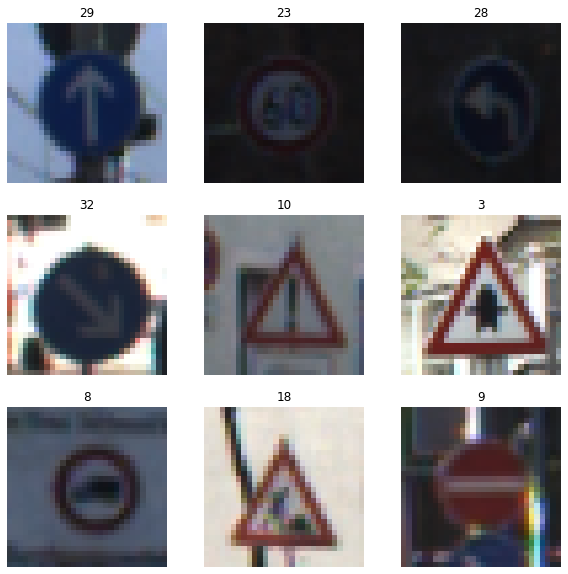

In [ ]:
# Print the first 9 images in train_ds.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # take 1 batch at a time
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

###Data Augmentation:
Introduce small random rotations and zooms exposing model to different aspects of the training data.  This will help slow down overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

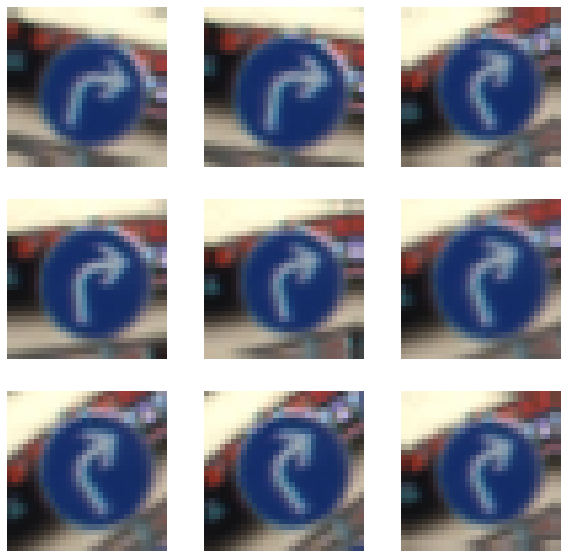

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

##Configure the dataset for performance:

*   Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

##Build the CNN model:
Added the Dropout layer to reduce the possibility of overfit.

In [ ]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers.experimental.preprocessing as preprocessing

num_classes=43

model = Sequential([           
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
  layers.experimental.preprocessing.RandomContrast(0.6),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes, activation='softmax')            
])


##Compile & summarize:
###Chose 'sparse_categorical_crossentropy' over 'categorical_crossentropy' because labels are:
1. mutually exclusive.
2. not one-hot encoded.

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 30, 30, 3)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 30, 30, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 32)         

##Train the model:

In [ ]:
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=32 )

Epoch 1/10
981/981 [==============================] - 6649s 7s/step - loss: 1.4161 - accuracy: 0.6084 - val_loss: 0.4177 - val_accuracy: 0.8862
Epoch 2/10
981/981 [==============================] - 79s 80ms/step - loss: 0.3587 - accuracy: 0.9003 - val_loss: 0.2073 - val_accuracy: 0.9461
Epoch 3/10
981/981 [==============================] - 77s 78ms/step - loss: 0.2066 - accuracy: 0.9437 - val_loss: 0.1371 - val_accuracy: 0.9649
Epoch 4/10
981/981 [==============================] - 75s 77ms/step - loss: 0.1521 - accuracy: 0.9592 - val_loss: 0.0953 - val_accuracy: 0.9786
Epoch 5/10
981/981 [==============================] - 77s 78ms/step - loss: 0.1153 - accuracy: 0.9679 - val_loss: 0.1212 - val_accuracy: 0.9693
Epoch 6/10
981/981 [==============================] - 80s 81ms/step - loss: 0.0878 - accuracy: 0.9752 - val_loss: 0.0994 - val_accuracy: 0.9753
Epoch 7/10
981/981 [==============================] - 78s 79ms/step - loss: 0.0777 - accuracy: 0.9780 - val_loss: 0.0824 - val_accuracy:

##Evaluate the model:

In [ ]:
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print('Val loss score:', val_loss)
print('Val accuracy:', val_acc)

Val loss score: 0.05875561758875847
Val accuracy: 0.9883943200111389


##Visualize training results:

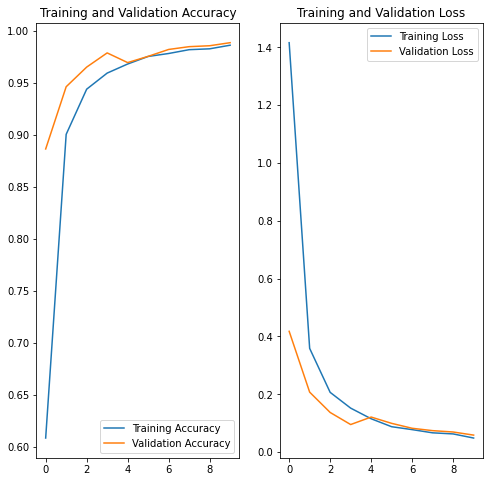

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Running predictions:
Loading the training data through tf.keras.preprocessing.image_dataset_from_directory has many positive attributes including the internal shuffling of training data, encapsulating the images and labels, and the creation of a validation dataset as mentioned earlier.  Another advantage allows us to implement the unused Test file to predict unseen images.



In [ ]:
#Load the unseen Test.csv file
from google.colab import files 
import io

uploaded = files.upload()
test_df = pd.read_csv(io.BytesIO(uploaded['Test.csv']))

Saving Test.csv to Test.csv


In [ ]:
data_path = '/content/drive/MyDrive/18-Mod32-Capstone4/gtsrb-german-traffic-sign'
test_img_path = data_path +'/' +test_df["Path"].values

In [ ]:
# Make and store predictions.  
preds = []

for ct in range(10000):  
  try:
    img = keras.preprocessing.image.load_img(test_img_path[ct], target_size=(30,30))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = predictions[0]
    preds.append(class_names[np.argmax(score)])
  except:
    print("err", test_img_path[ct])
    break    

In [ ]:
# Store the actual correct labels
actual = []

for i in range(ct+1):
  actual.append(str(test_df.iloc[i].ClassId))


###Print the first 25 Test file images noting True/Predicted values:

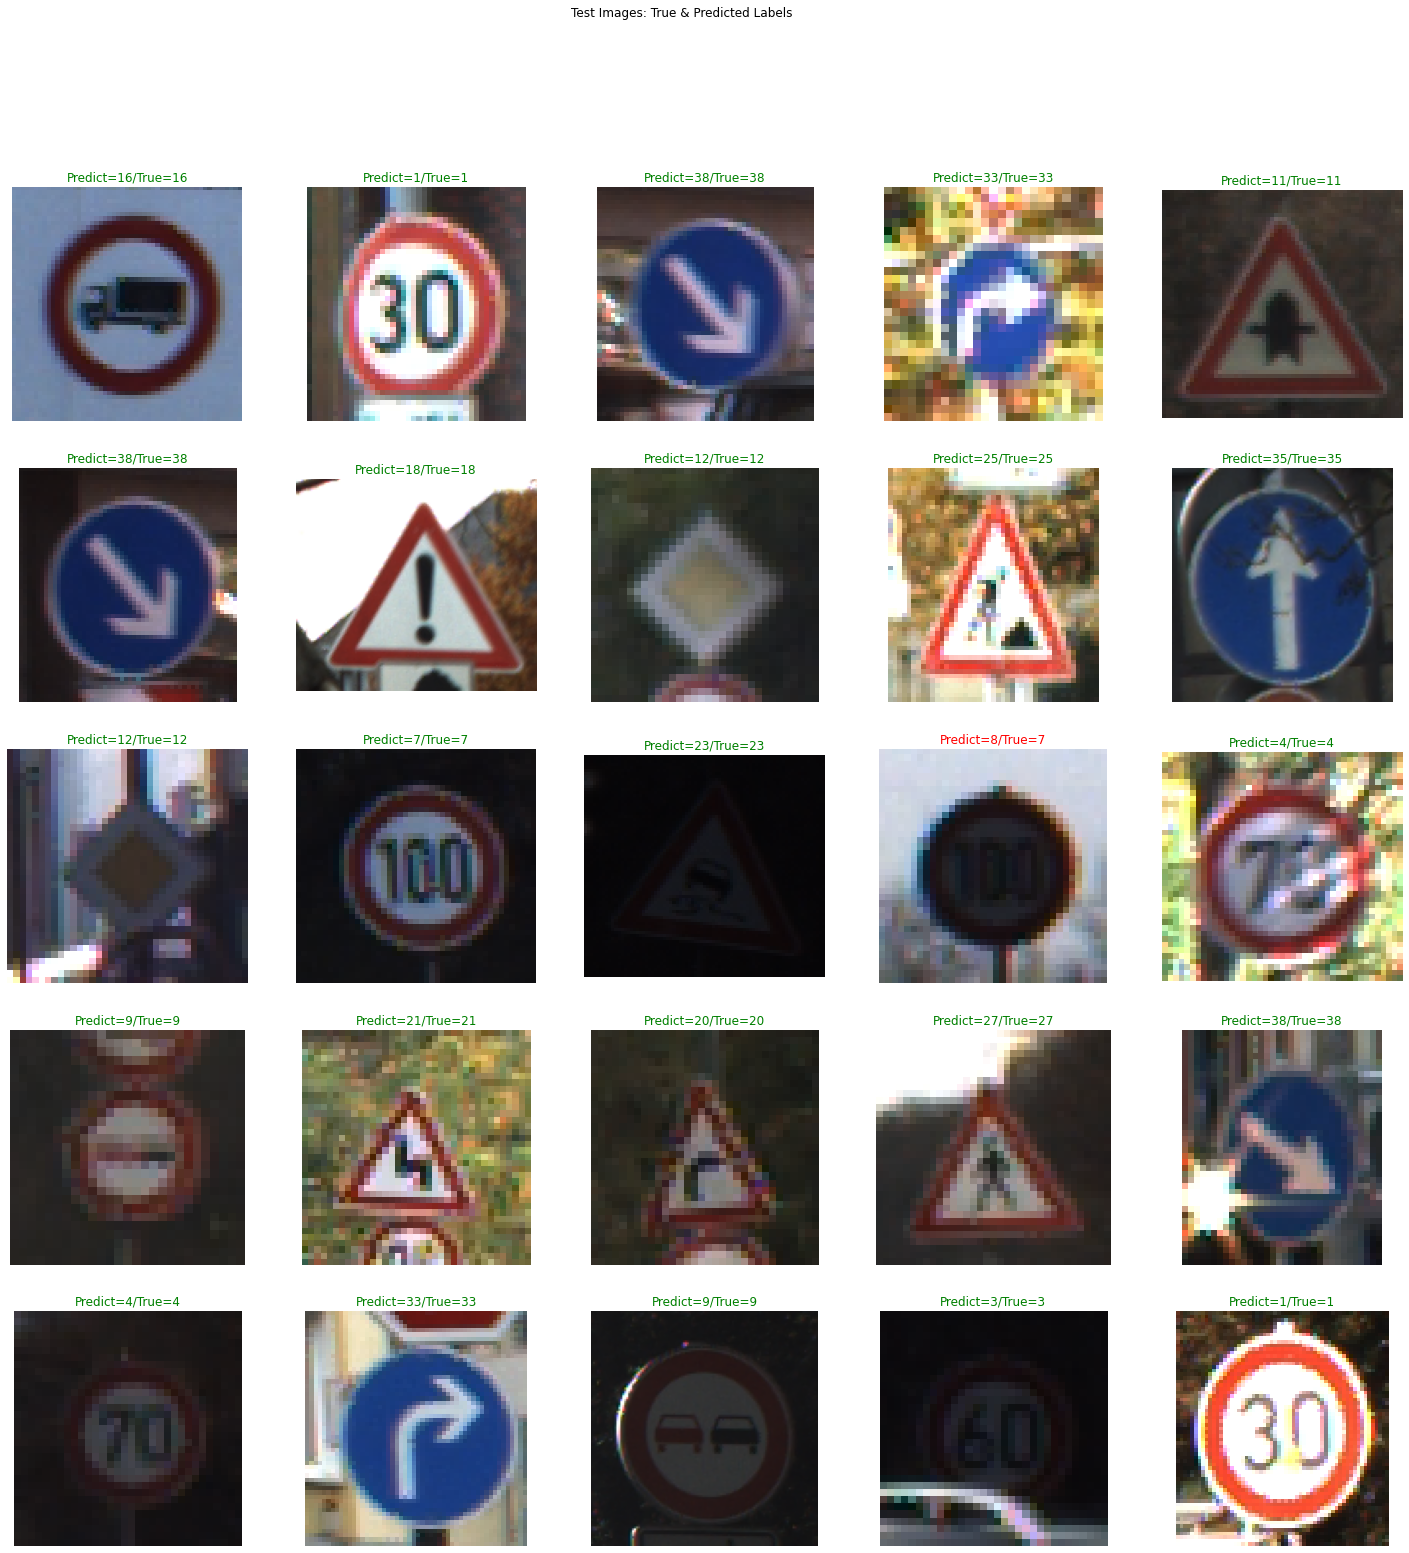

In [ ]:
from PIL import Image
from matplotlib.image import imread

plt.figure(figsize=(25,25))  
for i in range(1, 26):
  ax = plt.subplot(5,5,i)
  img = imread(test_img_path[i-1])
  plt.imshow(img)
  col='g'
  if(actual[i-1] != preds[i-1]):
    col='r'
  plt.title("Predict={}/True={}".format(preds[i-1], actual[i-1]), color = col)
  plt.axis("off")

plt.suptitle('Test Images: True & Predicted Labels')
plt.show()

In [ ]:
label_array = class_names
for i in range(len(class_names)):
  label_array[i] = int(class_names[i])

label_array.sort()

##Confusion matrix showing raw numbers of corresponding actual labels.

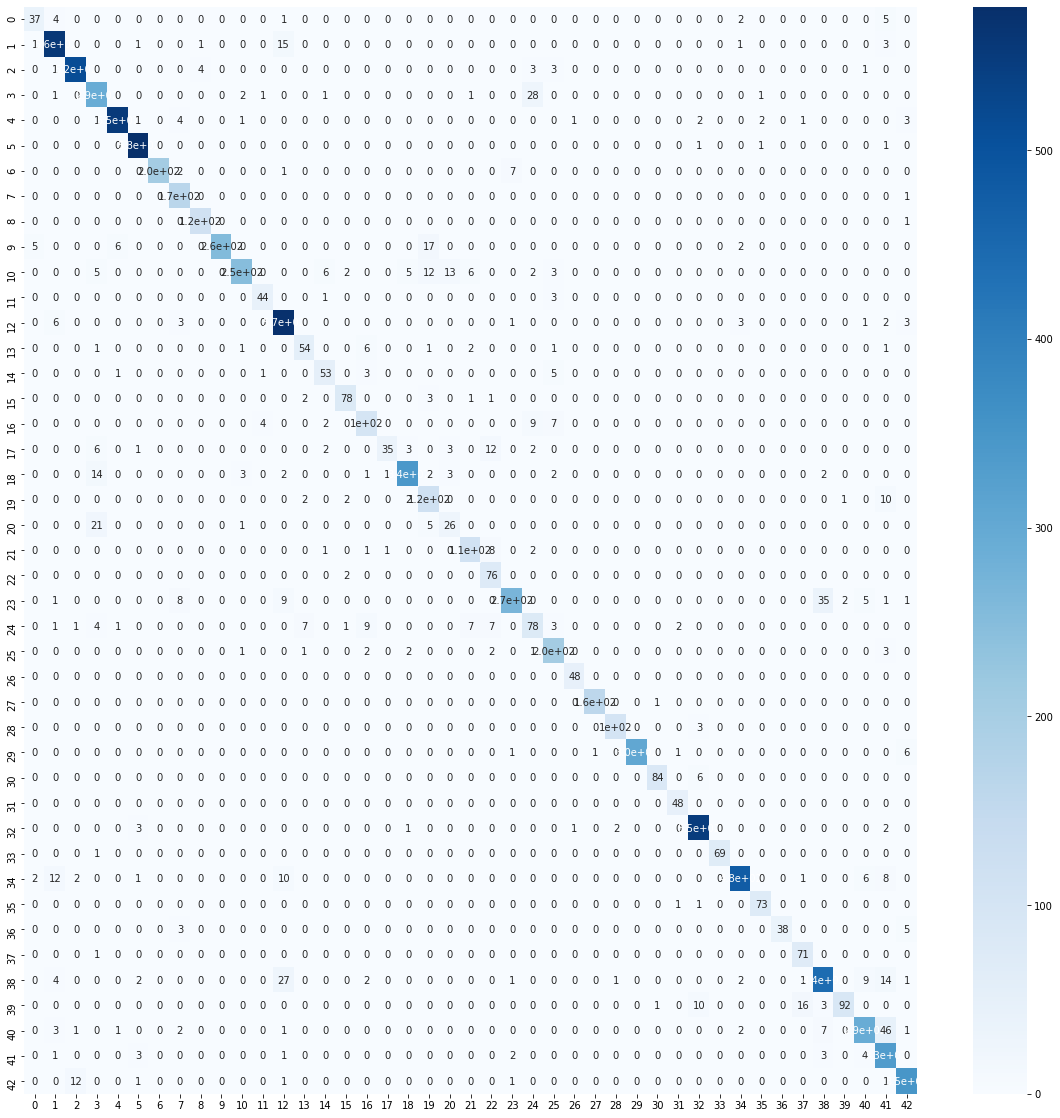

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(actual, preds)
cm_df = pd.DataFrame(cm, index = label_array,  columns = label_array)
plt.figure(figsize = (20,20))
sns.heatmap(cm_df, annot=True, cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(actual, preds))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79        49
           1       0.94      0.96      0.95       579
          10       0.97      0.98      0.97       527
          11       0.84      0.89      0.87       329
          12       0.98      0.97      0.98       569
          13       0.98      0.99      0.99       579
          14       1.00      0.95      0.98       215
          15       0.88      0.99      0.94       167
          16       0.96      0.99      0.97       116
          17       1.00      0.90      0.94       286
          18       0.97      0.82      0.89       303
          19       0.88      0.92      0.90        48
           2       0.89      0.97      0.93       591
          20       0.82      0.81      0.81        67
          21       0.80      0.84      0.82        63
          22       0.92      0.92      0.92        85
          23       0.81      0.82      0.81       122
          24       0.95    

##Conclusions:

###Is 98.8% training(39k) and validation(8k) accuracy good enough? 
While 98.8% accuracy seems relatively good, I don't believe it is good enough for real world usage.  Especially because the prediction(n=10k) results lagged behind substantially with weighted precision results at 93%.  The three worst predictors had small sample sizes that could have affected the outcomes:
1. Label 27 58% correct n=53
2. Label 30 62% correct n=121
3. Label 29 72% correct n=78

I would assume the model would have a higher accuracy for ideal conditions where the images are well lit with no inclement weather.  On the other hand, poorly lit images, images obstructed by other objects, and poor weather conditions would probably lower the accuracy.  Some other noises to consider would be the speed of the vehicle and at what distance is the image read from the CPU.  I would assume some type of thresholds would have to be introduced for confidence in the accuracies obtained depending all the variables just mentioned.

###Further considerations:
1. Separate test images into categories based on quality.  Evaluating accuracies of image prediction depending on image quality should be insightfull.
2. Specifically investigate the highest percent of wrongly predicted labels and attempt to find patterns and possible causations.
3. Continue research and development focusing on vehicle speed and distance of images taken.


###Acknowlegements:
A huge shout-out to the many publications, youtube videos, and all the selfless individuals willing to share insights online. Specific inspiration was acquired from the following: 

*   Keras - Image Classification from Scratch
*   Colab Classification
* TensorFlow - Image Classification
* Youtuber - sentdex
* Youtuber - deeplizzard
* Jakob Salamonnson - Thinkful Mentor
